In [1]:
# ! pip install wfdb

In [2]:
# ! pip install tensorflow

In [3]:
# ! pip install Keras

In [4]:
! pip install deepdish

In [5]:
from __future__ import division, print_function


import deepdish as dd
import deepdish.io as ddio
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import time

from glob import glob
from scipy.signal import find_peaks
from sklearn import preprocessing
from tqdm import tqdm
from wfdb import rdrecord, rdann
from scipy.io import loadmat

from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv1D, Dense, add, Dropout, MaxPooling1D, Activation, BatchNormalization, Lambda
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, classification_report

The data is provided by
https://physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.
Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable
reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

    Code		Description
    N		Normal beat (displayed as . by the PhysioBank ATM, LightWAVE, pschart, and psfd)
    L		Left bundle branch block beat
    R		Right bundle branch block beat
    B		Bundle branch block beat (unspecified)
    A		Atrial premature beat
    a		Aberrated atrial premature beat
    J		Nodal (junctional) premature beat
    S		Supraventricular premature or ectopic beat (atrial or nodal)
    V		Premature ventricular contraction
    r		R-on-T premature ventricular contraction
    F		Fusion of ventricular and normal beat
    e		Atrial escape beat
    j		Nodal (junctional) escape beat
    n		Supraventricular escape beat (atrial or nodal)
    E		Ventricular escape beat
    /		Paced beat
    f		Fusion of paced and normal beat
    Q		Unclassifiable beat
    ?		Beat not classified during learning

In [6]:
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

You already have the data.


In [7]:
def get_records():
    paths = glob('mitdb/*.atr')
    paths = [path[:-4].rsplit("/", 1)[1] for path in paths]
    paths.sort()
    return paths

# Preprocess data

In [8]:
INPUT_SIZE = 256
features = ['MLII', 'V1', 'V2', 'V4', 'V5']  # signal names
nums = get_records()                         # file names without extension

In [9]:
def split_data():
    test_set = ['101', '105', '114', '118', '124', '201', '210', '217']
    train_set = [x for x in nums if x not in test_set]
    data_saver(train_set, 'mitdb/train.hdf5', 'mitdb/trainlabel.hdf5')
    data_saver(test_set, 'mitdb/test.hdf5', 'mitdb/testlabel.hdf5')

In [10]:
def data_saver(dataset, dataset_name, labels_name):
    classes = ['N', 'V', '/', 'A', 'F', '~']
    classes_length = len(classes)  # used for creating masks
    datadict, data_label = dict(), dict()

    """
    {
        "N": [],
        "V": [],
        "/": [],
        "A": [],
        "F": [],
        "~": []
    }
    """
    for feature in features:
        datadict[feature] = list()
        data_label[feature] = list()

    data_process(dataset, classes, datadict, data_label)
    add_noise_to_dataset(classes_length, data_label, datadict)

    dd.io.save(dataset_name, datadict)
    dd.io.save(labels_name, data_label)

In [11]:
def data_process(dataset, classes, datadict, data_label):
    for num in tqdm(dataset):
        record = rdrecord('mitdb/' + num, smooth_frames=True)

        signals_channel_0 = preprocessing.scale(np.nan_to_num(record.p_signal[:, 0])).tolist()
        signals_channel_1 = preprocessing.scale(np.nan_to_num(record.p_signal[:, 1])).tolist()

        peaks, _ = find_peaks(signals_channel_0, distance=150)

        feature0, feature1 = record.sig_name[0], record.sig_name[1]

        # skip the first and last peaks to have enough range of the sample
        for peak in peaks[1:-1]:
            start, end = peak - INPUT_SIZE // 2, peak + INPUT_SIZE // 2
            annotation = rdann('mitdb/' + num, extension='atr', sampfrom=start, sampto=end, return_label_elements=['symbol'])

            # remove some of "N" which breaks the balance of dataset
            if len(annotation.symbol) == 1 and (annotation.symbol[0] in classes) and (annotation.symbol[0] != "N" or np.random.random() < 0.15):
                y = [0] * len(classes)
                y[classes.index(annotation.symbol[0])] = 1
                data_label[feature0].append(y)
                data_label[feature1].append(y)
                datadict[feature0].append(signals_channel_0[start:end])
                datadict[feature1].append(signals_channel_1[start:end])

In [12]:
def add_noise_to_dataset(classes_length, data_label, datadict):
        noises = add_noise()
        for feature in ["MLII", "V1"]:
            d = np.array(datadict[feature])
            if len(d) > 15 * 10 ** 3:
                n = np.array(noises["trainset"])
            else:
                n = np.array(noises["testset"])

            datadict[feature] = np.concatenate((d, n))
            size, _ = n.shape
            l = np.array(data_label[feature])
            noise_label = [0] * classes_length
            noise_label[-1] = 1

            noise_label = np.array([noise_label] * size)
            data_label[feature] = np.concatenate((l, noise_label))

In [13]:
def add_noise():
    noises = dict()
    noises["trainset"] = list()
    noises["testset"] = list()

    
    testlabel = list(csv.reader(open('training2017/REFERENCE.csv')))
    
    for i, label in enumerate(testlabel):
        if label[1] == '~':
            filename = 'training2017/' + label[0] + '.mat'
            from scipy.io import loadmat
            noise = loadmat(filename)
            noise = noise['val']
            _, size = noise.shape
            noise = noise.reshape(size, )
            noise = np.nan_to_num(noise)  # removing NaNs and Infs
            from scipy.signal import resample
            noise = resample(noise, int(
                len(noise) * 360 / 300))  # resample to match the data sampling rate 360(mit), 300(cinc)
            from sklearn import preprocessing
            noise = preprocessing.scale(noise)
            noise = noise / 1000 * 6  # rough normalize, to be improved
            from scipy.signal import find_peaks
            peaks, _ = find_peaks(noise, distance=150)
            choices = 10  # 256*10 from 9000
            picked_peaks = np.random.choice(peaks, choices, replace=False)
            for j, peak in enumerate(picked_peaks):
                if peak > INPUT_SIZE // 2 and peak < len(noise) - INPUT_SIZE // 2:
                    start, end = peak - INPUT_SIZE // 2, peak + INPUT_SIZE // 2
                    if i > len(testlabel) / 6:
                        noises["trainset"].append(noise[start:end].tolist())
                    else:
                        noises["testset"].append(noise[start:end].tolist())
    return noises

In [14]:
start_time = time.time()
# split_data()

# Training

## Utility functions

In [15]:
def loaddata(input_size, feature):
    trainData = ddio.load('mitdb/train.hdf5')
    testlabelData = ddio.load('mitdb/trainlabel.hdf5')
    X = np.float32(trainData[feature])
    print("[+] X:")
    print(X)
    y = np.float32(testlabelData[feature])
    print("[+] y:")
    print(y)
    att = np.concatenate((X, y), axis=1)
    print("[+] Att:")
    print(att)
    np.random.shuffle(att)
    X, y = att[:, :input_size], att[:, input_size:]
    valData = ddio.load('mitdb/test.hdf5')
    vallabelData = ddio.load('mitdb/testlabel.hdf5')
    Xval = np.float32(valData[feature])
    yval = np.float32(vallabelData[feature])
    return (X, y, Xval, yval)

In [16]:
def mkdir_recursive(path):
    if path == "":
        return
    sub_path = os.path.dirname(path)
    if not os.path.exists(sub_path):
        mkdir_recursive(sub_path)
    if not os.path.exists(path):
        print("Creating directory " + path)
        os.mkdir(path)

In [17]:
def PR_ROC_curves(ytrue, ypred, classes, ypred_mat):
    ybool = ypred == ytrue
    f, ax = plt.subplots(3, 4, figsize=(10, 10))
    ax = [a for i in ax for a in i]

    e = -1
    for c in classes:
        idx1 = [n for n, x in enumerate(ytrue) if classes[x] == c]
        idx2 = [n for n, x in enumerate(ypred) if classes[x] == c]
        idx = idx1 + idx2
        if idx == []:
            continue
        bi_ytrue = ytrue[idx]
        bi_prob = ypred_mat[idx, :]
        bi_ybool = np.array(ybool[idx])
        bi_yscore = np.array([bi_prob[x][bi_ytrue[x]] for x in range(len(idx))])
        try:
            print("AUC for {}: {}".format(c, roc_auc_score(bi_ybool + 0, bi_yscore)))
            e += 1
        except ValueError:
            continue
        ppvs, senss, thresholds = precision_recall_curve(bi_ybool, bi_yscore)
        cax = ax[2 * e]
        cax.plot(ppvs, senss, lw=2, label="Model")
        cax.set_xlim(-0.008, 1.05)
        cax.set_ylim(0.0, 1.05)
        cax.set_title("Class {}".format(c))
        cax.set_xlabel('Sensitivity (Recall)')
        cax.set_ylabel('PPV (Precision)')
        cax.legend(loc=3)

        fpr, tpr, thresholds = roc_curve(bi_ybool, bi_yscore)
        cax2 = ax[2 * e + 1]
        cax2.plot(fpr, tpr, lw=2, label="Model")
        cax2.set_xlim(-0.1, 1.)
        cax2.set_ylim(0.0, 1.05)
        cax2.set_title("Class {}".format(c))
        cax2.set_xlabel('1 - Specificity')
        cax2.set_ylabel('Sensitivity')
        cax2.legend(loc=4)

    mkdir_recursive("results")
    plt.savefig("results/model_prec_recall_and_roc.eps",
                dpi=400,
                format='eps',
                bbox_inches='tight')
    plt.close()


In [18]:
def plot_confusion_matrix(y_true, y_pred, classes, feature,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    mkdir_recursive('results')
    fig.savefig('results/confusionMatrix-mlii.eps', format='eps', dpi=1000)
    return ax

In [19]:
def print_results(model, Xval, yval, classes):
    model2 = model
    model.load_weights('models/MLII-latest.hdf5')
    # to combine different trained models. On testing
    
    ypred_mat = model.predict(Xval)
    
    ypred_mat = ypred_mat[:, 0]
    yval = yval[:, 0]

    ytrue = np.argmax(yval, axis=1)
    yscore = np.array([ypred_mat[x][ytrue[x]] for x in range(len(yval))])
    ypred = np.argmax(ypred_mat, axis=1)
    print(classification_report(ytrue, ypred))
    plot_confusion_matrix(ytrue, ypred, classes, feature=32, normalize=False)
    print("F1 score:", f1_score(ytrue, ypred, average=None))
    PR_ROC_curves(ytrue, ypred, classes, ypred_mat)


## Defining the model:

In [20]:
class EcgModel(object):
    def first_convolution_block(self, inputs):
        layer = Conv1D(filters=32,
                       kernel_size=16,
                       padding='same',
                       strides=1,
                       kernel_initializer='he_normal')(inputs)
        layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)

        shortcut = MaxPooling1D(pool_size=1,
                                strides=1)(layer)

        layer = Conv1D(filters=32,
                       kernel_size=16,
                       padding='same',
                       strides=1,
                       kernel_initializer='he_normal')(layer)
        layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        layer = Dropout(0.2)(layer)
        layer = Conv1D(filters=32,
                       kernel_size=16,
                       padding='same',
                       strides=1,
                       kernel_initializer='he_normal')(layer)
        return add([shortcut, layer])

    def main_loop_blocks(self, layer):
        filter_length = 32
        n_blocks = 15
        for block_index in range(n_blocks):
            def zeropad(x):
                y = K.zeros_like(x)
                return K.concatenate([x, y], axis=2)

            def zeropad_output_shape(input_shape):
                shape = list(input_shape)
                assert len(shape) == 3
                shape[2] *= 2
                return tuple(shape)

            subsample_length = 2 if block_index % 2 == 0 else 1
            shortcut = MaxPooling1D(pool_size=subsample_length)(layer)

            # 5 is chosen instead of 4 from the original model
            if block_index % 4 == 0 and block_index > 0:
                # double size of the network and match the shapes of both branches
                shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)
                filter_length *= 2

            layer = BatchNormalization()(layer)
            layer = Activation('relu')(layer)
            layer = Conv1D(filters=filter_length,
                           kernel_size=16,
                           padding='same',
                           strides=subsample_length,
                           kernel_initializer='he_normal')(layer)
            layer = BatchNormalization()(layer)
            layer = Activation('relu')(layer)
            layer = Dropout(0.2)(layer)
            layer = Conv1D(filters=filter_length,
                           kernel_size=16,
                           padding='same',
                           strides=1,
                           kernel_initializer='he_normal')(layer)
            layer = add([shortcut, layer])
        return layer

    def output_block(self, layer, inputs):
        classes = ['N', 'V', '/', 'A', 'F', '~']
        len_classes = len(classes)
        layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        outputs = TimeDistributed(Dense(len_classes, activation='softmax'))(layer)
        model = Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.summary()
        return model

    def create_network(self):
        inputs = Input(shape=(256, 1), name='input')
        layer = self.first_convolution_block(inputs)
        layer = self.main_loop_blocks(layer)
        return self.output_block(layer, inputs)


In [21]:
class Train(object):
    def __init__(self):
        mkdir_recursive('models')
        self.xv = None
        self.yv = None
        self.classes = None
        self.model = None

    @staticmethod
    def run(X, y, Xval=None, yval=None):
        classes = ['N', 'V', '/', 'A', 'F', '~']

        x = np.expand_dims(X, axis=2)

        
        xv = np.expand_dims(Xval, axis=2)
        (m, n) = y.shape

        print("-----")
        print(m)
        print(n)
        print("-----")

        y = y.reshape((m, 1, n))
        (mvl, nvl) = yval.shape
        yv = yval.reshape((mvl, 1, nvl))

        model = EcgModel().create_network()

        callbacks = [
            ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.01, verbose=1),
            TensorBoard(log_dir='./logs', histogram_freq=10, write_graph=True, write_grads=False, write_images=True),
            ModelCheckpoint('models/{}-latest.hdf5'.format("MLII"), monitor='val_loss', save_best_only=False, verbose=1, period=10)
        ]

        if model is None:
            print("none")

        H = model.fit(x, y,
                  validation_data=(xv, yv),
                  epochs=50,
                  batch_size=256,
                  callbacks=callbacks,
                  initial_epoch=0)
        
        # Plot training & validation accuracy values
        plt.plot(H.history['accuracy'])
        plt.plot(H.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(H.history['loss'])
        plt.plot(H.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        
        return (model, xv, yv, classes)

In [22]:
(X, y, Xval, yval) = loaddata(256, "MLII")

[+] X:
[[-2.7795628e-01 -2.5207630e-01 -3.0383626e-01 ... -1.9156480e-02
   5.8483455e-02  1.1024341e-01]
 [-4.0735614e-01 -3.8147619e-01 -3.2971624e-01 ... -7.0916437e-02
  -4.5036457e-02 -1.9156480e-02]
 [ 1.1024341e-01  1.6200337e-01  1.3612339e-01 ...  1.1024341e-01
   1.1024341e-01  1.1024341e-01]
 ...
 [ 3.4534474e-04  3.6154487e-04  3.7135973e-04 ...  7.1554905e-04
   7.2404329e-04  7.3409878e-04]
 [ 2.6782041e-03  4.2591202e-03  5.8382354e-03 ...  4.3132114e-03
   4.3793935e-03  2.8295030e-03]
 [-9.7649114e-04 -1.0027420e-03 -1.0283404e-03 ... -1.9492710e-03
  -2.1063504e-03 -2.1766378e-03]]
[+] y:
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
[+] Att:
[[-2.7795628e-01 -2.5207630e-01 -3.0383626e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.0735614e-01 -3.8147619e-01 -3.2971624e-01 ...  1.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.1024341e-01  1.6200337e-01  1.3612339e-01 

-----
22817
6
-----
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 32)      544         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 32)      0           batch_normalization[0][0]        
__________________________________________________________________________

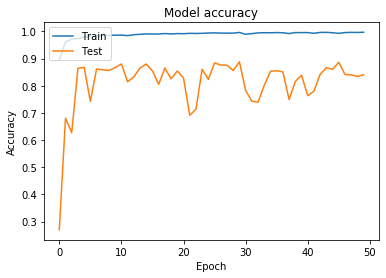

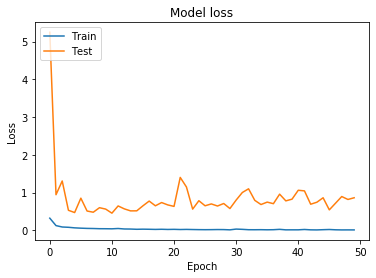

(<tensorflow.python.keras.engine.training.Model at 0x7fce88836590>,
 array([[[-1.75289690e-01],
         [-2.32726514e-01],
         [-2.32726514e-01],
         ...,
         [-1.36998460e-01],
         [-1.94435298e-01],
         [-2.32726514e-01]],
 
        [[-6.34784400e-01],
         [-6.15638793e-01],
         [-6.15638793e-01],
         ...,
         [-4.62473869e-01],
         [-4.81619477e-01],
         [-5.00765085e-01]],
 
        [[-4.12703976e-02],
         [ 3.53120491e-02],
         [ 3.53120491e-02],
         ...,
         [-1.17852844e-01],
         [-1.94435298e-01],
         [-2.32726514e-01]],
 
        ...,
 
        [[ 1.08480232e-03],
         [-2.19310611e-03],
         [-5.84538188e-03],
         ...,
         [-4.34195041e-04],
         [-3.07900045e-04],
         [-2.57695472e-04]],
 
        [[-4.04831674e-03],
         [-4.05391725e-03],
         [-4.08366416e-03],
         ...,
         [-5.39610861e-03],
         [-6.85710739e-03],
         [-8.47339723e-

In [23]:
Train().run(X, y, Xval, yval)

In [24]:
print("Training finished in: " + str(time.time() - start_time))

Training finished in: 10928.806210756302


# Prediction

In [25]:
def cincData():
    __download_cinc_data()

    testlabel = []
    __read_data(testlabel)

    high = len(testlabel) - 1
    num = np.random.randint(1, high)
    filename, label = testlabel[num - 1]
    filename = 'training2017/' + filename + '.mat'

    data = loadmat(filename)
    print("The record of " + filename)
    data = data['val']
    _, size = data.shape
    data = data.reshape(size, )
    
    return data, label


In [26]:
def __download_cinc_data():
    cmd = "curl -O https://archive.physionet.org/challenge/2017/training2017.zip"
    os.system(cmd)
    os.system("unzip training2017.zip")

In [27]:
def __read_data(testlabel):
    with open('training2017/REFERENCE.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            testlabel.append([row[0], row[1]])
            line_count += 1
        print(f'Processed {line_count} lines.')

In [28]:
def predict(data, label, peaks):
    classesM = ['N', 'Ventricular', 'Paced', 'A', 'F', 'Noise']
    predicted, result = predictByPart(data, peaks)
    sumPredict = sum(predicted[x][1] for x in range(len(predicted)))
    avgPredict = sumPredict / len(predicted)
    print("The average of the predict is:", avgPredict)
    print("The most predicted label is {} with {:3.1f}% certainty".format(classesM[avgPredict.argmax()],
                                                                          100 * max(avgPredict[0])))
    sec_idx = avgPredict.argsort()[0][-2]
    print("The second predicted label is {} with {:3.1f}% certainty".format(classesM[sec_idx],
                                                                            100 * avgPredict[0][sec_idx]))
    print("The original label of the record is " + label)
    print("Result:")
    print(result)

In [29]:
def predictByPart(data, peaks):
    classesM = ['N', 'Ventricular', 'Paced', 'A', 'F', 'Noise']
    predicted = list()
    result = ""
    counter = [0] * len(classesM)

    model = load_model('models/MLII-latest.hdf5')
    
    for i, peak in enumerate(peaks[3:-1]):
        total_n = len(peaks)
        start, end = peak - INPUT_SIZE // 2, peak + INPUT_SIZE // 2
        prob = model.predict(data[:, start:end])
        prob = prob[:, 0]
        ann = np.argmax(prob)
        counter[ann] += 1
        if classesM[ann] != "N":
            print("The {}/{}-record classified as {} with {:3.1f}% certainty".format(i, total_n, classesM[ann], 100 * prob[0, ann]))
        result += "(" + classesM[ann] + ":" + str(round(100 * prob[0, ann], 1)) + "%)"
        predicted.append([classesM[ann], prob])
        if classesM[ann] != 'N' and prob[0, ann] > 0.95:
            import matplotlib.pyplot as plt
            plt.plot(data[:, start:end][0, :, 0], )
            mkdir_recursive('results')
            plt.savefig('results/hazard-' + classesM[ann] + '.png', format="png", dpi=300)
            plt.close()
    result += "{}-N, {}-Venticular, {}-Paced, {}-A, {}-F, {}-Noise".format(counter[0], counter[1], counter[2], counter[3], counter[4], counter[5])
    return predicted, result

In [30]:
data, label = cincData()

Processed 8528 lines.
The record of training2017/A06289.mat


In [31]:
from scipy.signal import resample
from sklearn import preprocessing
from scipy.signal import find_peaks



def preprocess(data):
    sr = 300
    data = np.nan_to_num(data)  # removing NaNs and Infs
    data = resample(data, int(len(data) * 360 / sr))  # resample to match the data sampling rate 360(mit), 300(cinc)
    data = preprocessing.scale(data)
    peaks, _ = find_peaks(data, distance=150)
    data = data.reshape(1, len(data))
    data = np.expand_dims(data, axis=2)  # required by Keras
    return data, peaks

In [32]:
data, peaks = preprocess(data)

In [33]:
predict(data, label, peaks)

The 3/55-record classified as Ventricular with 54.8% certainty
The 9/55-record classified as A with 96.7% certainty
The 13/55-record classified as A with 56.7% certainty
The 18/55-record classified as A with 94.5% certainty
The 19/55-record classified as A with 66.2% certainty
The 23/55-record classified as Ventricular with 73.5% certainty
The 24/55-record classified as A with 91.9% certainty
The 29/55-record classified as A with 95.0% certainty
The 34/55-record classified as A with 97.5% certainty
The 38/55-record classified as Ventricular with 80.7% certainty
The 39/55-record classified as A with 99.9% certainty
The average of the predict is: [[8.0156213e-01 4.3196879e-02 3.9744085e-05 1.4795382e-01 6.9554383e-03
  2.9192219e-04]]
The most predicted label is N with 80.2% certainty
The second predicted label is A with 14.8% certainty
The original label of the record is O
Result:
(N:100.0%)(N:100.0%)(N:100.0%)(Ventricular:54.8%)(N:91.4%)(N:100.0%)(N:100.0%)(N:99.8%)(N:100.0%)(A:96.7%)(